In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#colors!

c_d = '#1b9e77'
c_i = '#d95f02'
c_c = '#7570b3'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import data

In [ ]:
# research article data

domestic_research = pd.read_csv('/content/drive/MyDrive/DSS132_final_project/data/domestic_brazil_research.csv')
international_research = pd.read_csv('/content/drive/MyDrive/DSS132_final_project/data/international_brazil_research.csv')
collaborative_research = pd.read_csv('/content/drive/MyDrive/DSS132_final_project/data/collaboration_brazil_research.csv')

domestic_research = domestic_research[domestic_research['Publication Year'] < 2022]
international_research = international_research[international_research['Publication Year'] < 2022]
collaborative_research = collaborative_research[collaborative_research['Publication Year'] < 2022]

domestic_research = domestic_research.reset_index(drop=True)
international_research = international_research.reset_index(drop=True)
collaborative_research = collaborative_research.reset_index(drop=True)


# deforestation data

deforestation_df = pd.read_csv('/content/drive/MyDrive/DSS132_final_project/data/brazil-world-bank-forest-area-percentage.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (13,20,48,52,58) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Pre-processing data

Aligning year ranges between the data

In [ ]:
min_year = max([min(domestic_research['Publication Year']), min(international_research['Publication Year']), min(collaborative_research['Publication Year']), min(deforestation_df['year'])])

deforestation_df = deforestation_df[deforestation_df['year']  >= min_year]
domestic_research = domestic_research[domestic_research['Publication Year'] >= min_year]
international_research = international_research[international_research['Publication Year'] >= min_year]
collaborative_research = collaborative_research[collaborative_research['Publication Year'] >= min_year]

deforestation_df = deforestation_df.reset_index(drop=True)
domestic_research = domestic_research.reset_index(drop=True)
international_research = international_research.reset_index(drop=True)
collaborative_research = collaborative_research.reset_index(drop=True)

Dataframes to hold final predictor/response data

In [ ]:
domestic_df = pd.DataFrame({'Year': np.arange(min_year, 2021), 'Deforestation_Rate': deforestation_df['Forest area (% of land area)']})
international_df = pd.DataFrame({'Year': np.arange(min_year, 2021), 'Deforestation_Rate': deforestation_df['Forest area (% of land area)']})
collaborative_df = pd.DataFrame({'Year': np.arange(min_year, 2021), 'Deforestation_Rate': deforestation_df['Forest area (% of land area)']})

Processing article data to get AR index citation metric

In [75]:
def calculate_AR_index(citations, year):
    
    citations = np.array(citations)
    n = citations.shape[0]
    array = np.arange(1, n+1)

    # reverse sorting
    citations = np.sort(citations)[::-1]           

    # computing h-index
    h_idx = np.max(np.minimum(citations, array))
    
    # computing AR index
    paper_age = 2022 - year
    AR = np.sqrt(sum(citations[0:h_idx-1]) / paper_age )
    
    return AR 

In [ ]:
def process_article_data(article_df, year_list):
    
    AR_index_list = []
    
    for year in year_list:
        article_df_year = article_df[article_df['Publication Year'] == year]
        AR_index_list.append(calculate_AR_index(article_df_year['Times Cited, All Databases'], year))
        
    return AR_index_list

In [ ]:
domestic_df['AR_Index'] = process_article_data(domestic_research, domestic_df['Year'])

international_df['AR_Index'] = process_article_data(international_research, international_df['Year'])

collaborative_df['AR_Index'] = process_article_data(collaborative_research, collaborative_df['Year'])

### Making time-shifted variables

In [ ]:
# def get_shift(df, steps_back, min_year):
    
#     df_shifted = pd.DataFrame({'Year': np.arange(min_year+steps_back, 2021)})
    
#     deforestation_list = np.asarray(df['Deforestation_Rate'])
#     deforestation_list = deforestation_list[steps_back:len(deforestation_list)]
#     df_shifted['Deforestation_Rate'] = deforestation_list
    
#     AR_list = np.asarray(df['AR_Index'])
#     AR_list = AR_list[0:len(AR_list)-steps_back]
#     df_shifted[f'AR_Index_{steps_back}_Year_Prev'] = AR_list
    
#     return df_shifted

In [ ]:
# domestic_df_list = [domestic_df]
# international_df_list = [international_df]
# collaborative_df_list = [collaborative_df]

# # time shifts of 1-5 years
# for i in range(1, 6):

#     domestic_df_list.append(get_shift(domestic_df, i, min_year)) 
#     international_df_list.append(get_shift(international_df, i, min_year)) 
#     collaborative_df_list.append(get_shift(collaborative_df, i, min_year)) 

In [ ]:
def get_forest_loss(df, shift_year, country_area):
    shifted_df = np.asarray(df['Deforestation_Rate'][:-shift_year])
    df_rate = df.loc[shift_year:, :].copy()
    df_rate.loc[:,f'previous_{shift_year}_year_forest_rate'] = shifted_df
    df_rate.loc[:,f'forest_loss_in_km_from_previous_{shift_year}_year'] = np.abs(df_rate['Deforestation_Rate']*country_area-df_rate[f'previous_{shift_year}_year_forest_rate']*country_area)
    df_rate_clean = pd.DataFrame({'Year':[],'forest_loss_in_km':[], 'AR_Index':[]})
    df_rate_clean['Year'] = df_rate.loc[:,'Year']
    df_rate_clean['forest_loss_in_km'] = df_rate.loc[:,f'forest_loss_in_km_from_previous_{shift_year}_year']
    df_rate_clean['AR_Index'] = df_rate.loc[:,'AR_Index']
    
    return df_rate_clean
    

In [ ]:
brazil_land_area = 8.5*(10**6)

domestic_df_rate = get_forest_loss(domestic_df, 1, brazil_land_area)
international_df_rate = get_forest_loss(international_df, 1, brazil_land_area)
collaborative_df_rate = get_forest_loss(collaborative_df, 1, brazil_land_area)

In [ ]:
def get_shift(df, steps_back, min_year):
    
    df_shifted = pd.DataFrame({'Year': np.arange(min_year+steps_back, 2021)})
    
    deforestation_list = np.asarray(df['forest_loss_in_km'])
    deforestation_list = deforestation_list[steps_back:len(deforestation_list)]
    df_shifted['forest_loss_in_km'] = deforestation_list
    
    AR_list = np.asarray(df['AR_Index'])
    AR_list = AR_list[0:len(AR_list)-steps_back]
    df_shifted[f'AR_Index_{steps_back}_Year_Prev'] = AR_list
    
    return df_shifted

In [ ]:
domestic_df_list = [domestic_df_rate]
international_df_list = [international_df_rate]
collaborative_df_list = [collaborative_df_rate]

for i in range(1, 6):

    domestic_df_list.append(get_shift(domestic_df_rate, i, min_year+1)) 
    international_df_list.append(get_shift(international_df_rate, i, min_year+1)) 
    collaborative_df_list.append(get_shift(collaborative_df_rate, i, min_year+1)) 

## Plots of raw data

### Deforestation rate timeseries

In [82]:
domestic_df_rate.head(2)

Year  forest_loss_in_km  AR_Index
1  1998.0        3845112.700  6.773109
2  1999.0        3845112.615  6.450480

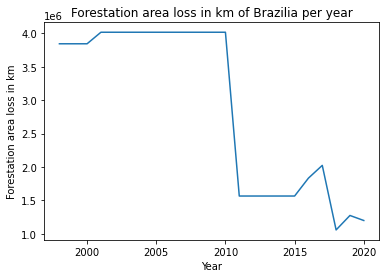

In [ ]:
# brazil_land_area = 8.5*(10**6)

# shifted_forest_rate = np.asarray(domestic_df['Deforestation_Rate'][:-1])
# domestic_df_rate = domestic_df[1:]
# domestic_df_rate['previous_year_forest_rate'] = shifted_forest_rate
# domestic_df_rate['forest_loss_in_km'] = np.abs(domestic_df_rate['Deforestation_Rate']*brazil_land_area - 
#                                                 domestic_df_rate['previous_year_forest_rate']*brazil_land_area)


plt.plot(domestic_df_rate['Year'], domestic_df_rate['forest_loss_in_km'])
plt.title(r'Forestation area loss in km of Brazilia per year')
plt.xlabel('Year')
plt.ylabel(r'Forestation area loss in km')
plt.show()

### AR index timeseries

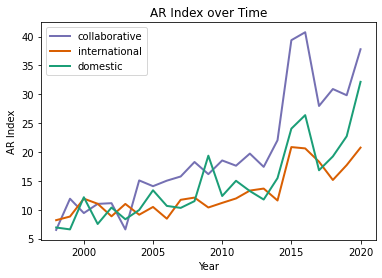

In [ ]:
plt.plot(collaborative_df_rate['Year'], collaborative_df_rate['AR_Index'], color=c_c, linewidth=2, label='collaborative')
plt.plot(international_df_rate['Year'], international_df_rate['AR_Index'], color=c_i, linewidth=2, label='international')
plt.plot(domestic_df_rate['Year'], domestic_df_rate['AR_Index'], color=c_d, linewidth=2, label='domestic')
plt.title('AR Index over Time')
plt.xlabel('Year')
plt.ylabel('AR Index')
plt.legend()
         
plt.show()

### Scatter plots of AR Index vs. Deforestation rate

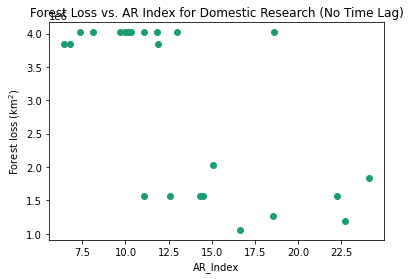

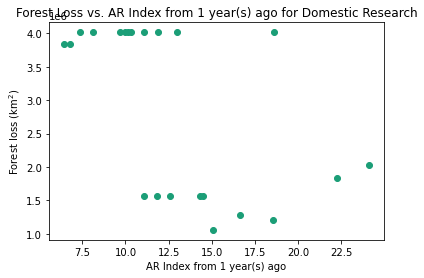

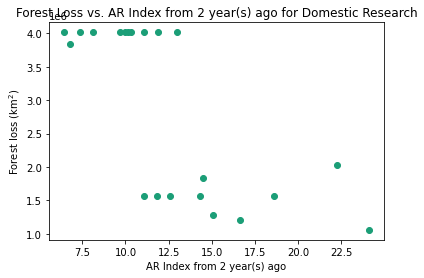

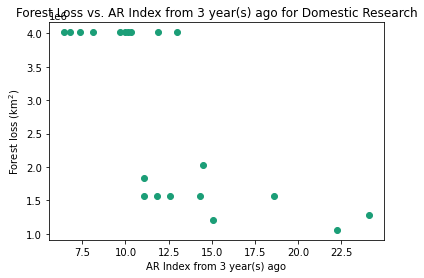

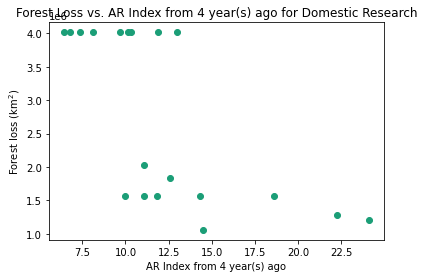

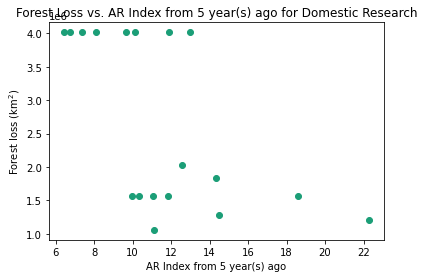

In [86]:
for i in range(0, 6):
    if i==0:
        plt.scatter(domestic_df_list[i]['AR_Index'], domestic_df_list[i]['forest_loss_in_km'], color=c_d)
        plt.xlabel('AR_Index')
        plt.ylabel(r'Forest loss (km$^2$)')
        plt.title('Forest Loss vs. AR Index for Domestic Research (No Time Lag)')
        plt.show()
    else:
        plt.scatter(domestic_df_list[i][f'AR_Index_{i}_Year_Prev'], domestic_df_list[i]['forest_loss_in_km'], color=c_d)
        plt.title(f'Forest Loss vs. AR Index from {i} year(s) ago for Domestic Research')
        plt.xlabel(f'AR Index from {i} year(s) ago')
        plt.ylabel('Forest loss (km$^2$)')
        plt.show()

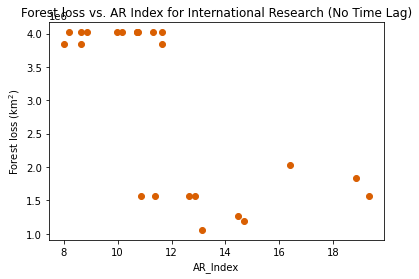

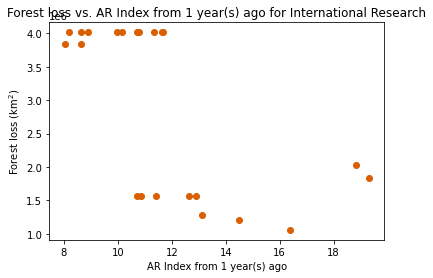

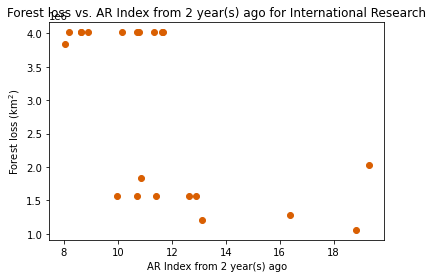

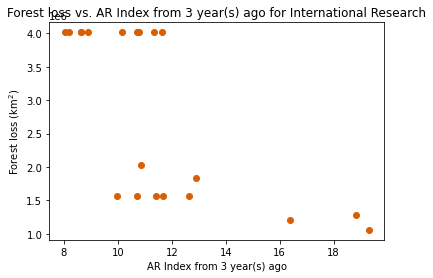

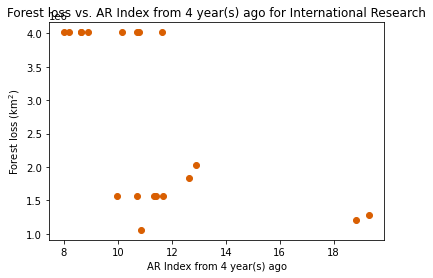

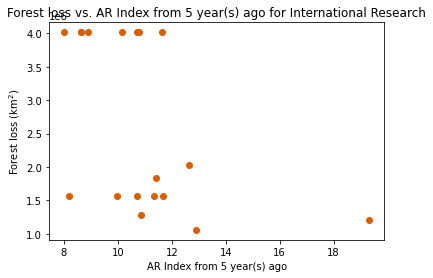

In [85]:
for i in range(0, 6):
    if i==0:
        plt.scatter(international_df_list[i]['AR_Index'], international_df_list[i]['forest_loss_in_km'], color=c_i)
        plt.xlabel('AR_Index')
        plt.ylabel(r'Forest loss (km$^2$)')
        plt.title('Forest loss vs. AR Index for International Research (No Time Lag)')
        plt.show()
    else:
        plt.scatter(international_df_list[i][f'AR_Index_{i}_Year_Prev'], international_df_list[i]['forest_loss_in_km'], color=c_i)
        plt.title(f'Forest loss vs. AR Index from {i} year(s) ago for International Research')
        plt.xlabel(f'AR Index from {i} year(s) ago')
        plt.ylabel('Forest loss (km$^2$)')
        plt.show()

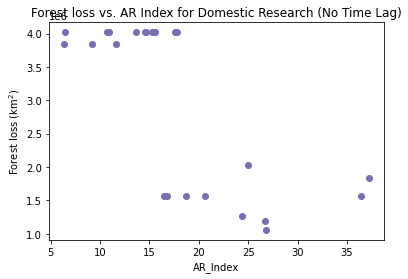

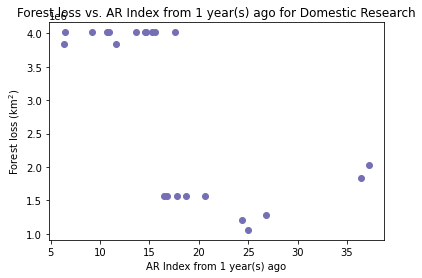

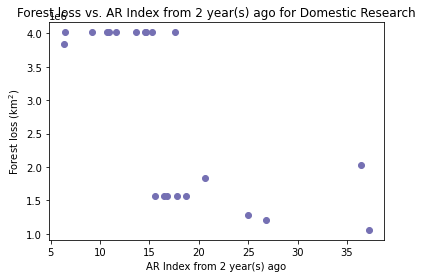

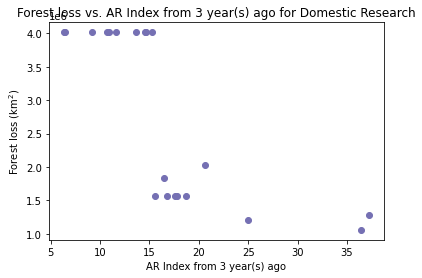

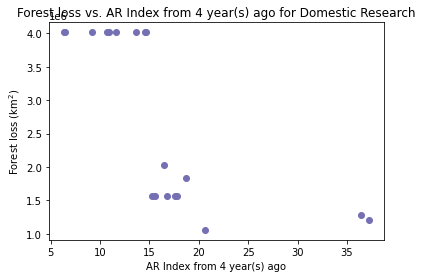

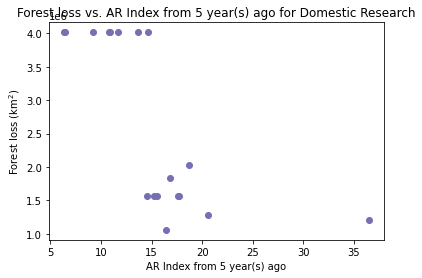

In [87]:
for i in range(0, 6):
    if i==0:
        plt.scatter(collaborative_df_list[i]['AR_Index'], collaborative_df_list[i]['forest_loss_in_km'], color=c_c)
        plt.xlabel('AR_Index')
        plt.ylabel(r'Forest loss (km$^2$)')
        plt.title('Forest loss vs. AR Index for Domestic Research (No Time Lag)')
        plt.show()
    else:
        plt.scatter(collaborative_df_list[i][f'AR_Index_{i}_Year_Prev'], collaborative_df_list[i]['forest_loss_in_km'], color=c_c)
        plt.title(f'Forest loss vs. AR Index from {i} year(s) ago for Domestic Research')
        plt.xlabel(f'AR Index from {i} year(s) ago')
        plt.ylabel('Forest loss (km$^2$)')
        plt.show()

# Model fitting

In [88]:
import statsmodels.api as sm
from scipy.interpolate import interp1d
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

import patsy as pt

## Linear regression and significance testing

### Domestic

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     17.16
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000462
Time:                        21:09:49   Log-Likelihood:                -348.32
No. Observations:                  23   AIC:                             700.6
Df Residuals:                      21   BIC:                             702.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        5.13e+06   5.72e+05      8.973      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


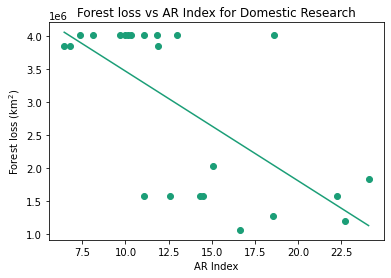

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     9.525
Date:                Wed, 04 May 2022   Prob (F-statistic):            0.00582
Time:                        21:09:49   Log-Likelihood:                -335.66
No. Observations:                  22   AIC:                             675.3
Df Residuals:                      20   BIC:                             677.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  4.83e+06 

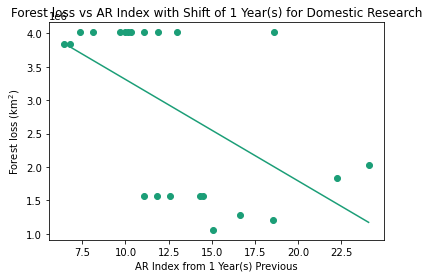

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     20.03
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000259
Time:                        21:09:49   Log-Likelihood:                -317.11
No. Observations:                  21   AIC:                             638.2
Df Residuals:                      19   BIC:                             640.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.297e+06 

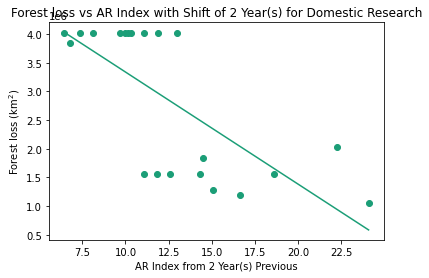

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     19.95
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000298
Time:                        21:09:49   Log-Likelihood:                -301.90
No. Observations:                  20   AIC:                             607.8
Df Residuals:                      18   BIC:                             609.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.242e+06 

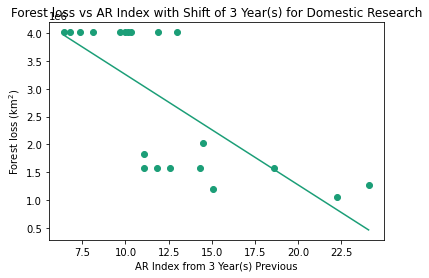

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     13.86
Date:                Wed, 04 May 2022   Prob (F-statistic):            0.00169
Time:                        21:09:49   Log-Likelihood:                -288.21
No. Observations:                  19   AIC:                             580.4
Df Residuals:                      17   BIC:                             582.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4.924e+06 

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


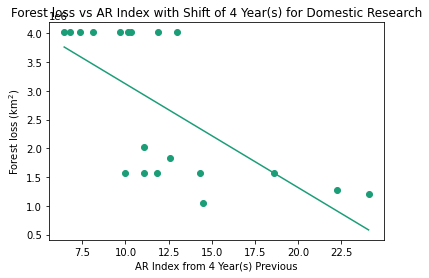

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     8.690
Date:                Wed, 04 May 2022   Prob (F-statistic):            0.00945
Time:                        21:09:50   Log-Likelihood:                -274.43
No. Observations:                  18   AIC:                             552.9
Df Residuals:                      16   BIC:                             554.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4.868e+06 

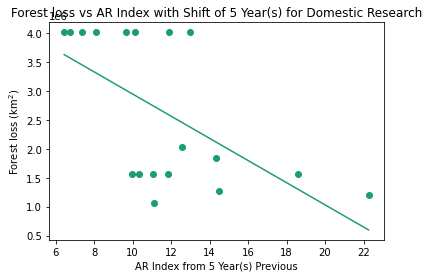

In [89]:
X = domestic_df_list[0]['AR_Index']
y = domestic_df_list[0]['forest_loss_in_km']
sk_model = sm.OLS(y, sm.add_constant(X))
results = sk_model.fit()
print(results.summary())
f = interp1d(domestic_df_list[0]['AR_Index'], results.predict(sm.add_constant(domestic_df_list[0]['AR_Index'])), bounds_error=False)
y_preds = f(domestic_df_list[0]['AR_Index'])
X_vis, y_preds = zip(*sorted(zip(domestic_df_list[0]['AR_Index'], y_preds)))
plt.scatter(domestic_df_list[0]['AR_Index'], domestic_df_list[0]['forest_loss_in_km'], color=c_d)
plt.plot(X_vis, y_preds, label='Predicted Rate', color=c_d)
plt.title(f'Forest loss vs AR Index for Domestic Research')
plt.xlabel('AR Index')
plt.ylabel(r'Forest loss (km$^2$)')
plt.show()

for i in range(1,6):
    X = domestic_df_list[i][f'AR_Index_{i}_Year_Prev']
    y = domestic_df_list[i]['forest_loss_in_km']
    sk_model = sm.OLS(y, sm.add_constant(X))
    results = sk_model.fit()
    print(results.summary())
    
    f = interp1d(domestic_df_list[i][f'AR_Index_{i}_Year_Prev'], results.predict(sm.add_constant(domestic_df_list[i][f'AR_Index_{i}_Year_Prev'])), bounds_error=False)
    y_preds = f(domestic_df_list[i][f'AR_Index_{i}_Year_Prev'])
    X_vis, y_preds = zip(*sorted(zip(domestic_df_list[i][f'AR_Index_{i}_Year_Prev'], y_preds)))
    plt.scatter(domestic_df_list[i][f'AR_Index_{i}_Year_Prev'], domestic_df_list[i]['forest_loss_in_km'], color=c_d)
    plt.plot(X_vis, y_preds, label='Predicted Rate', color=c_d)
    plt.title(f'Forest loss vs AR Index with Shift of {i} Year(s) for Domestic Research')
    plt.xlabel(f'AR Index from {i} Year(s) Previous')
    plt.ylabel(r'Forest loss (km$^2$)')
    plt.show()

### International

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     19.45
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000244
Time:                        21:10:48   Log-Likelihood:                -347.65
No. Observations:                  23   AIC:                             699.3
Df Residuals:                      21   BIC:                             701.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.259e+06   7.84e+05      7.986      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


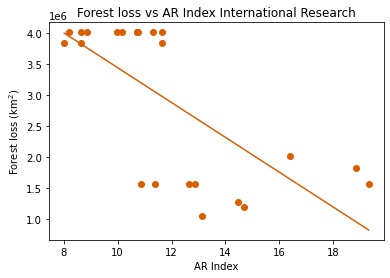

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     13.70
Date:                Wed, 04 May 2022   Prob (F-statistic):            0.00141
Time:                        21:10:49   Log-Likelihood:                -334.21
No. Observations:                  22   AIC:                             672.4
Df Residuals:                      20   BIC:                             674.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.933e+06 

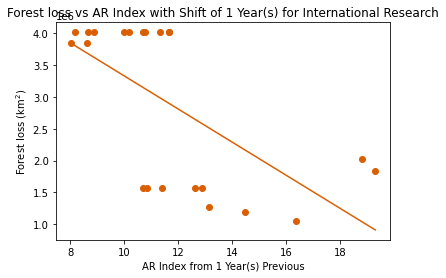

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     11.61
Date:                Wed, 04 May 2022   Prob (F-statistic):            0.00295
Time:                        21:10:49   Log-Likelihood:                -319.66
No. Observations:                  21   AIC:                             643.3
Df Residuals:                      19   BIC:                             645.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.761e+06 

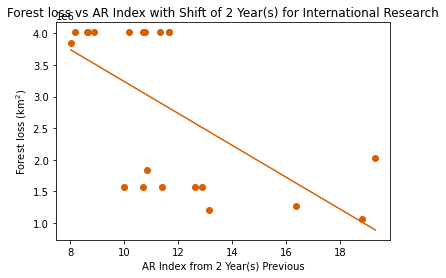

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     15.96
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000850
Time:                        21:10:49   Log-Likelihood:                -303.01
No. Observations:                  20   AIC:                             610.0
Df Residuals:                      18   BIC:                             612.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.986e+06 

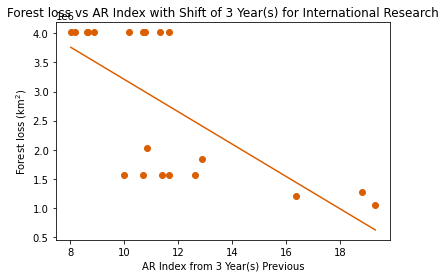

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     10.07
Date:                Wed, 04 May 2022   Prob (F-statistic):            0.00556
Time:                        21:10:49   Log-Likelihood:                -289.46
No. Observations:                  19   AIC:                             582.9
Df Residuals:                      17   BIC:                             584.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.618e+06 

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


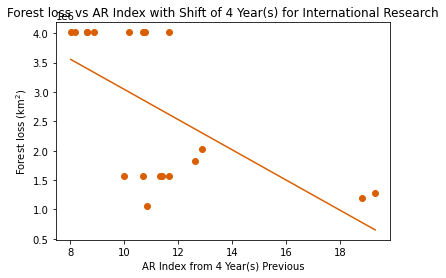

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     4.934
Date:                Wed, 04 May 2022   Prob (F-statistic):             0.0411
Time:                        21:10:49   Log-Likelihood:                -275.92
No. Observations:                  18   AIC:                             555.8
Df Residuals:                      16   BIC:                             557.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.316e+06 

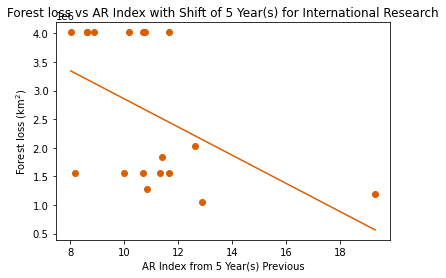

In [91]:
X = international_df_list[0]['AR_Index']
y = international_df_list[0]['forest_loss_in_km']
sk_model = sm.OLS(y, sm.add_constant(X))
results = sk_model.fit()
print(results.summary())
f = interp1d(international_df_list[0]['AR_Index'], results.predict(sm.add_constant(international_df_list[0]['AR_Index'])), bounds_error=False)
y_preds = f(international_df_list[0]['AR_Index'])
X_vis, y_preds = zip(*sorted(zip(international_df_list[0]['AR_Index'], y_preds)))
plt.scatter(international_df_list[0]['AR_Index'], international_df_list[0]['forest_loss_in_km'], color=c_i)
plt.plot(X_vis, y_preds, label='Predicted Rate', color=c_i)
plt.title(f'Forest loss vs AR Index International Research')
plt.xlabel('AR Index')
plt.ylabel(r'Forest loss (km$^2$)')
plt.show()

for i in range(1,6):
    X = international_df_list[i][f'AR_Index_{i}_Year_Prev']
    y = international_df_list[i]['forest_loss_in_km']
    sk_model = sm.OLS(y, sm.add_constant(X))
    results = sk_model.fit()
    print(results.summary())
    
    f = interp1d(international_df_list[i][f'AR_Index_{i}_Year_Prev'], results.predict(sm.add_constant(international_df_list[i][f'AR_Index_{i}_Year_Prev'])), bounds_error=False)
    y_preds = f(international_df_list[i][f'AR_Index_{i}_Year_Prev'])
    X_vis, y_preds = zip(*sorted(zip(international_df_list[i][f'AR_Index_{i}_Year_Prev'], y_preds)))
    plt.scatter(international_df_list[i][f'AR_Index_{i}_Year_Prev'], international_df_list[i]['forest_loss_in_km'], color=c_i)
    plt.plot(X_vis, y_preds, label='Predicted Rate', color=c_i)
    plt.title(f'Forest loss vs AR Index with Shift of {i} Year(s) for International Research')
    plt.xlabel(f'AR Index from {i} Year(s) Previous')
    plt.ylabel(r'Forest loss (km$^2$)')
    plt.show()

    # y_pred = sk_model.predict(x)
    # residual = y-y_preds
    # plt.scatter(y, residual)
    # plt.show()

### Collaborative

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     23.43
Date:                Wed, 04 May 2022   Prob (F-statistic):           8.75e-05
Time:                        21:11:29   Log-Likelihood:                -346.58
No. Observations:                  23   AIC:                             697.2
Df Residuals:                      21   BIC:                             699.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.894e+06    4.5e+05     10.883      0.0

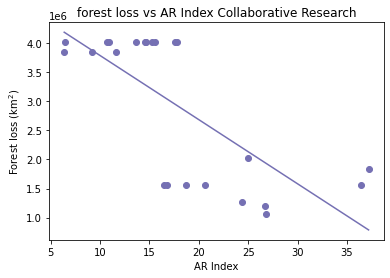

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     17.17
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000503
Time:                        21:11:30   Log-Likelihood:                -333.13
No. Observations:                  22   AIC:                             670.3
Df Residuals:                      20   BIC:                             672.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4.709e+06 

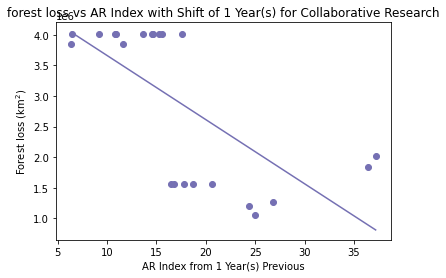

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     17.80
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000465
Time:                        21:11:30   Log-Likelihood:                -317.73
No. Observations:                  21   AIC:                             639.5
Df Residuals:                      19   BIC:                             641.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4.675e+06 

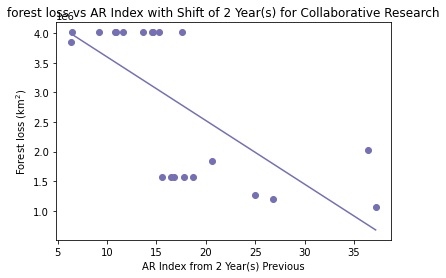

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     22.31
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000170
Time:                        21:11:30   Log-Likelihood:                -301.30
No. Observations:                  20   AIC:                             606.6
Df Residuals:                      18   BIC:                             608.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4.735e+06 

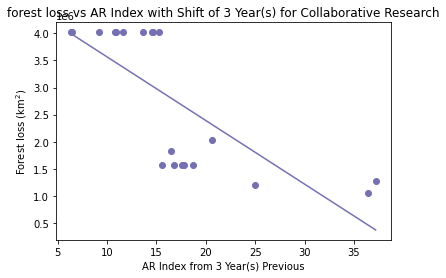

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     16.73
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000762
Time:                        21:11:31   Log-Likelihood:                -287.37
No. Observations:                  19   AIC:                             578.7
Df Residuals:                      17   BIC:                             580.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  4.52e+06 

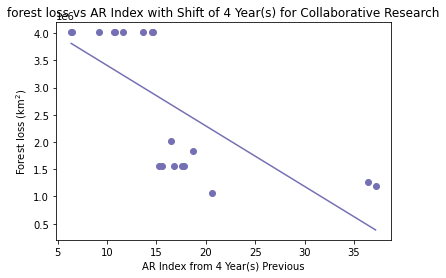

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     14.41
Date:                Wed, 04 May 2022   Prob (F-statistic):            0.00159
Time:                        21:11:31   Log-Likelihood:                -272.56
No. Observations:                  18   AIC:                             549.1
Df Residuals:                      16   BIC:                             550.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4.658e+06 

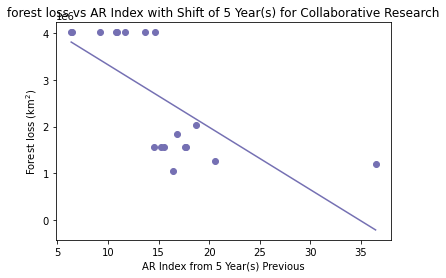

In [94]:
X = collaborative_df_list[0]['AR_Index']
y = collaborative_df_list[0]['forest_loss_in_km']
sk_model = sm.OLS(y, sm.add_constant(X))
results = sk_model.fit()
print(results.summary())
f = interp1d(collaborative_df_list[0]['AR_Index'], results.predict(sm.add_constant(collaborative_df_list[0]['AR_Index'])), bounds_error=False)
y_preds = f(collaborative_df_list[0]['AR_Index'])
X_vis, y_preds = zip(*sorted(zip(collaborative_df_list[0]['AR_Index'], y_preds)))
plt.scatter(collaborative_df_list[0]['AR_Index'], collaborative_df_list[0]['forest_loss_in_km'], color=c_c)
plt.plot(X_vis, y_preds, label='Predicted Rate', color=c_c)
plt.title(f'forest loss vs AR Index Collaborative Research')
plt.xlabel('AR Index')
plt.ylabel(r'Forest loss (km$^2$)')
plt.show()

for i in range(1,6):
    X = collaborative_df_list[i][f'AR_Index_{i}_Year_Prev']
    y = collaborative_df_list[i]['forest_loss_in_km']
    sk_model = sm.OLS(y, sm.add_constant(X))
    results = sk_model.fit()
    print(results.summary())
    
    f = interp1d(collaborative_df_list[i][f'AR_Index_{i}_Year_Prev'], results.predict(sm.add_constant(collaborative_df_list[i][f'AR_Index_{i}_Year_Prev'])), bounds_error=False)
    y_preds = f(collaborative_df_list[i][f'AR_Index_{i}_Year_Prev'])
    X_vis, y_preds = zip(*sorted(zip(collaborative_df_list[i][f'AR_Index_{i}_Year_Prev'], y_preds)))
    plt.scatter(collaborative_df_list[i][f'AR_Index_{i}_Year_Prev'], collaborative_df_list[i]['forest_loss_in_km'], color=c_c)
    plt.plot(X_vis, y_preds, label='Predicted Rate', color=c_c)
    plt.title(f'forest loss vs AR Index with Shift of {i} Year(s) for Collaborative Research')
    plt.xlabel(f'AR Index from {i} Year(s) Previous')
    plt.ylabel(r'Forest loss (km$^2$)')
    plt.show()

## Polynomial regression and bootstrapping

In [ ]:
def calc_MSE_polynomial_fit(poly_order, X_train, X_val, y_train, y_val):
    if poly_order == 1:
        X_train_poly = X_train
        X_val_poly = X_val
    else:
        # Transform X to appropriate polynomial
        poly = PolynomialFeatures(poly_order)
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.fit_transform(X_val)
    
    # Fit the polynomial regression
    regr_poly = linear_model.LinearRegression()
    regr_poly.fit(X_train_poly, y_train)
    
    # Make predictions using the linear regression
    y_pred_poly_val = regr_poly.predict(X_val_poly)
    y_pred_poly_train = regr_poly.predict(X_train_poly)
    
    # Calculate the MSE for both the val and training sets
    MSE_val = mean_squared_error(y_val, y_pred_poly_val)
    MSE_train = mean_squared_error(y_train, y_pred_poly_train)
    
    return MSE_train, MSE_val

In [ ]:
def poly_order_cv(X,y,k,poly_order_max):
    mses = pd.DataFrame()
    fold = 0

    kf = KFold(n_splits=k, shuffle=True, random_state=0) 
    for train_index, val_index in kf.split(X):
        # Separate each array into respective variables
        X_fold_train = X[train_index]
        y_fold_train = y[train_index]
        X_fold_val = X[val_index]
        y_fold_val = y[val_index]
    
        # Adding a column in the X matrices for the intercept
        X_fold_train = np.array(X_fold_train).reshape(-1, 1) 
        X_fold_val = np.array(X_fold_val).reshape(-1, 1) 

        # Calculate the MSE for each polynomial order
        MSE_val_array = []
        MSE_train_array = []
        
        for poly_order in range(1,poly_order_max+1):
            [MSE_train, MSE_val] = calc_MSE_polynomial_fit(poly_order, X_fold_train, X_fold_val, y_fold_train, y_fold_val)
            MSE_val_array.append(MSE_val)
            MSE_train_array.append(MSE_train) 
        mses[fold] = MSE_val_array
        fold = fold+1

    # Average the MSE across folds
    mses['mses_ave'] = mses.mean(axis=1)

    
    # one std error rule
    min_mse_model = mses[mses.mses_ave == min(mses.mses_ave)]
    min_mse_model_folds = min_mse_model.drop(['mses_ave'], axis=1)
    one_std = np.std(min_mse_model_folds.to_numpy())
    upper_range = np.float(min(mses.mses_ave) + one_std)
    order_range = mses[mses.mses_ave < upper_range]
    optimal_order = order_range.index[0] + 1

    
    poly_order_MSE_ave_val_min = optimal_order
    MSE_ave_val_min = mses['mses_ave'].iloc[order_range.index[0]]
    
    return MSE_ave_val_min, poly_order_MSE_ave_val_min

In [ ]:
def bootstrap_polynomial_sample_analysis(X,y, poly_order, x_array):
    
    x_bootstrap_min = min(X)
    x_bootstrap_max = max(X)
    
    X_reshape = np.array(X).reshape(-1, 1)

    # Generate features up to the specified polynomial order 
    if poly_order == 1:
        X_poly = X_reshape
    else:
        # Transform X to appropriate polynomial
        poly = PolynomialFeatures(poly_order)
        X_poly = poly.fit_transform(X_reshape)
    
    # Fit the polynomial regression
    regr_poly = linear_model.LinearRegression()    
    regr_poly.fit(X_poly, y)
    
    # You do no want to extrapolate the bootstrapped regression beyond the range of the bootstrap data
    # For values below the lowest income in the bootstrap sample and above the highest income in the 
    # bootstrap sample, place NaN values. 
    entries_below_bootstrap_min = sum(x_array<x_bootstrap_min)
    y_pred_below_bootstrap_min = np.full(entries_below_bootstrap_min, np.nan)

    entries_above_bootstrap_max = sum(x_array>x_bootstrap_max)
    y_pred_above_bootstrap_max = np.full(entries_above_bootstrap_max, np.nan)

    # For entries within the bootstrap sample range, used your fitted regression to predict solar installation
    incomes_within_bootstrap_data =x_array[entries_below_bootstrap_min:(len(x_array) - entries_above_bootstrap_max)]
    if poly_order == 1:
        incomes_within_bootstrap_data = incomes_within_bootstrap_data.reshape(-1, 1)
    else:
        # Transform X to appropriate polynomial
        poly = PolynomialFeatures(poly_order)
        incomes_within_bootstrap_data = poly.fit_transform(incomes_within_bootstrap_data.reshape(-1, 1))
    y_pred_within_bootstrap_data_range = regr_poly.predict(incomes_within_bootstrap_data)

    # Concatenate the predicted solar installations for all three regions (below the lowest income in the bootstrap
    # sample, within the income data in the bootstrap sample, and above the highest income in the bootstrap sample)
    y_pred = np.concatenate((y_pred_below_bootstrap_min, y_pred_within_bootstrap_data_range, y_pred_above_bootstrap_max))

    return y_pred

In [ ]:
def bootstrap_polynomial_analysis(df, variable_of_interest, response, poly_order_max, k):
    X = df[variable_of_interest]
    X = X.reset_index(drop = True)
    y = df[response]
    y = y.reset_index(drop = True)
    
    x_array = np.linspace(min(X), max(X), 100)
        
    # first determine the best polynomial order using cross-validation
    MSE_ave_val_min, poly_order_MSE_ave_val_min = poly_order_cv(X,y,k,poly_order_max)
    print('The average MSE of the valuation sets:', MSE_ave_val_min)
    print('This occured when using a polynomial of order:', poly_order_MSE_ave_val_min)
    
    # bootstrap analysis given this selected polynomial order
    y_pred_bootstrap = pd.DataFrame()
    for i in range(0,1000):
        df_bootstrap = df.sample(n=len(df), replace=True)
        X_bootstrap  = df_bootstrap[variable_of_interest]
        X_bootstrap  = X_bootstrap.reset_index(drop = True)
        y_bootstrap  = df_bootstrap[response]
        y_bootstrap  = y_bootstrap.reset_index(drop = True)

        y_pred = bootstrap_polynomial_sample_analysis(X_bootstrap, y_bootstrap, poly_order_MSE_ave_val_min, x_array)
        y_pred_bootstrap[i] = y_pred
        
    y_pred_bootstrap_summary = pd.DataFrame()
    y_pred_bootstrap_summary['median'] = [np.nanpercentile(y_pred_bootstrap.loc[i], 50) for i in range(0, len(x_array))]  # median is 50th percentile
    y_pred_bootstrap_summary['95_CI_high'] = [np.nanpercentile(y_pred_bootstrap.loc[i], 97.5) for i in range(0, len(x_array))]
    y_pred_bootstrap_summary['95_CI_low'] = [np.nanpercentile(y_pred_bootstrap.loc[i], 2.5) for i in range(0, len(x_array))]

    
    return y_pred_bootstrap_summary, x_array, MSE_ave_val_min, poly_order_MSE_ave_val_min

In [ ]:
def plot_polynomial_bootstrap_analysis(domestic_df, international_df, collaborative_df, variable_of_interest, k):
    
    response = 'forest_loss_in_km'
    poly_order_max = 5
    
    #print('Domestic Research:')
    [y_bootstrap_summary_domestic, x_array_domestic, MSE_min_domestic, optimal_poly_order_domestic] = bootstrap_polynomial_analysis(domestic_df, variable_of_interest, response, poly_order_max, k)
    #print('International Research:')
    [y_bootstrap_summary_international, x_array_international, MSE_min_international, optimal_poly_order_international] = bootstrap_polynomial_analysis(international_df, variable_of_interest, response, poly_order_max, k)
    #print('Collaborative Research:')
    [y_bootstrap_summary_collaborative, x_array_collaborative, MSE_min_collaborative, optimal_poly_order_collaborative] = bootstrap_polynomial_analysis(collaborative_df, variable_of_interest, response, poly_order_max, k)
    
    
    plt.scatter(domestic_df[variable_of_interest], domestic_df[response], s=5, color=c_d)
    plt.plot(x_array_domestic, y_bootstrap_summary_domestic['median'], c_d)
    plt.fill_between(x_array_domestic, y_bootstrap_summary_domestic['95_CI_low'], y_bootstrap_summary_domestic['95_CI_high'], facecolor = c_d, alpha = 0.5, label='domestic')
    
    plt.scatter(international_df[variable_of_interest], international_df[response], s=5, color=c_i)
    plt.plot(x_array_international, y_bootstrap_summary_international['median'], c_i)
    plt.fill_between(x_array_international, y_bootstrap_summary_international['95_CI_low'], y_bootstrap_summary_international['95_CI_high'], facecolor = c_i, alpha = 0.5, label='international')
   
    plt.scatter(collaborative_df[variable_of_interest], collaborative_df[response], s=5, color=c_c)
    plt.plot(x_array_collaborative, y_bootstrap_summary_collaborative['median'], c_c)
    plt.fill_between(x_array_collaborative, y_bootstrap_summary_collaborative['95_CI_low'], y_bootstrap_summary_collaborative['95_CI_high'], facecolor = c_c, alpha = 0.5, label='collaborative')
   
    plt.xlabel(variable_of_interest)
    plt.ylabel(f'Deforestation Rate (km$^2$ per Year)')
    plt.title(f'Deforestation Rate vs. {variable_of_interest}')
    plt.legend()
    plt.show()

In [ ]:
def timelag_analysis_polynomial_bootstrap(df_list):
    
    response = 'forest_loss_in_km'
    poly_order_max = 3
    
    MSE_list = []
    optimal_poly_list = []
    
    for i in range(1, 6):
        k = len(df_list[i])
        variable_of_interest = f'AR_Index_{i}_Year_Prev'
        [y_bootstrap_summary, x_array, MSE_min, optimal_poly_order] = bootstrap_polynomial_analysis(df_list[i], variable_of_interest, response, poly_order_max, k)
        MSE_list.append(MSE_min)
        optimal_poly_list.append(optimal_poly_order)
        
    timelag_analysis_df = pd.DataFrame({'Lag': np.arange(1, 6), 'MSE': MSE_list, 'optimal poly order': optimal_poly_list})    
    
    return timelag_analysis_df

In [ ]:
def print_timelag_analysis(timelag_analysis_df):
    
    best_row = timelag_analysis_df.iloc[timelag_analysis_df['MSE'].idxmin()]
    min_MSE = best_row['MSE']
    best_poly = best_row['optimal poly order']
    optimal_lag = best_row['Lag']
    
    print(f'Optimal lag: {optimal_lag}')
    print(f'Occured with polynomial order {best_poly}')
    
    return min_MSE, best_poly, optimal_lag

### Timelag analysis

In [ ]:
print('-----------Domestic Research---------------')
print_timelag_analysis(timelag_analysis_polynomial_bootstrap(domestic_df_list))
print('-----------International Research---------------')
print_timelag_analysis(timelag_analysis_polynomial_bootstrap(international_df_list))
print('-----------Collaborative Research---------------')
print_timelag_analysis(timelag_analysis_polynomial_bootstrap(collaborative_df_list))

-----------Domestic Research---------------
The average MSE of the valuation sets: 1139078183997.6218
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

The average MSE of the valuation sets: 861724721860.5198
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

The average MSE of the valuation sets: 886780380065.0726
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

The average MSE of the valuation sets: 1034753982546.677
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

The average MSE of the valuation sets: 1223149648958.747
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

Optimal lag: 2.0
Occured with polynomial order 1.0
-----------International Research---------------
The average MSE of the valuation sets: 982362226774.8718
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

The average MSE of the valuation sets: 1086810015139.0471
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

The average MSE of the valuation sets: 948960840031.9281
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

The average MSE of the valuation sets: 1170055682933.93
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

The average MSE of the valuation sets: 1687012485346.2327
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

Optimal lag: 3.0
Occured with polynomial order 1.0
-----------Collaborative Research---------------
The average MSE of the valuation sets: 963642966588.5875
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

The average MSE of the valuation sets: 955576546824.8497
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

The average MSE of the valuation sets: 879186829008.2976
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

The average MSE of the valuation sets: 1037143268193.5648
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

The average MSE of the valuation sets: 1835475105918.1782
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

Optimal lag: 3.0
Occured with polynomial order 1.0


(879186829008.2976, 1.0, 3.0)

### Plots for optimal lag

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


The average MSE of the valuation sets: 908260506321.2029
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

The average MSE of the valuation sets: 993319476972.4766
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

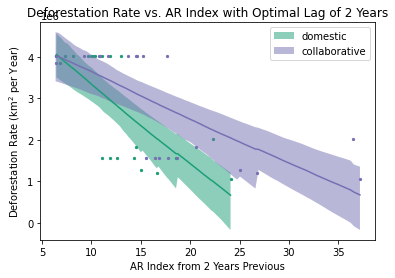

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


The average MSE of the valuation sets: 1624058637593.0283
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

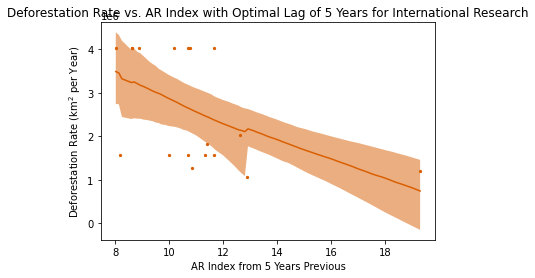

In [ ]:
response = 'forest_loss_in_km'
poly_order_max = 5


variable_of_interest = 'AR_Index_2_Year_Prev'

[y_bootstrap_summary_domestic, x_array_domestic, MSE_min_domestic, optimal_poly_order_domestic] = bootstrap_polynomial_analysis(domestic_df_list[2], variable_of_interest, response, poly_order_max, len(domestic_df_list[2]))

plt.scatter(domestic_df_list[2][variable_of_interest], domestic_df_list[2][response], s=5, color=c_d)
plt.plot(x_array_domestic, y_bootstrap_summary_domestic['median'], c_d)
plt.fill_between(x_array_domestic, y_bootstrap_summary_domestic['95_CI_low'], y_bootstrap_summary_domestic['95_CI_high'], facecolor = c_d, alpha = 0.5, label='domestic')

[y_bootstrap_summary_collaborative, x_array_collaborative, MSE_min_collaborative, optimal_poly_order_collaborative] = bootstrap_polynomial_analysis(collaborative_df_list[2], variable_of_interest, response, poly_order_max, len(collaborative_df_list[2]))
plt.scatter(collaborative_df_list[2][variable_of_interest], collaborative_df_list[2][response], s=5, color=c_c)
plt.plot(x_array_collaborative, y_bootstrap_summary_collaborative['median'], c_c)
plt.fill_between(x_array_collaborative, y_bootstrap_summary_collaborative['95_CI_low'], y_bootstrap_summary_collaborative['95_CI_high'], facecolor = c_c, alpha = 0.5, label='collaborative')

plt.xlabel('AR Index from 2 Years Previous')
plt.ylabel(f'Forest loss (km$^2$)')
plt.title(f'Forest loss vs. AR Index with Optimal Lag of 2 Years')
plt.legend()
plt.show()



variable_of_interest = 'AR_Index_5_Year_Prev'

[y_bootstrap_summary_international, x_array_international, MSE_min_international, optimal_poly_order_international] = bootstrap_polynomial_analysis(international_df_list[5], variable_of_interest, response, poly_order_max, len(international_df_list[5]))
plt.scatter(international_df_list[5][variable_of_interest],international_df_list[5][response], s=5, color=c_i)
plt.plot(x_array_international, y_bootstrap_summary_international['median'], c_i)
plt.fill_between(x_array_international, y_bootstrap_summary_international['95_CI_low'], y_bootstrap_summary_international['95_CI_high'], facecolor = c_i, alpha = 0.5, label='international')
plt.xlabel('AR Index from 5 Years Previous')
plt.ylabel(f'Forest loss (km$^2$)')
plt.title(f'Deforestation Rate vs. AR Index with Optimal Lag of 5 Years for International Research')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


The average MSE of the valuation sets: 1223977676700.3198
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

The average MSE of the valuation sets: 1747387104603.825
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

The average MSE of the valuation sets: 1624058637593.0283
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

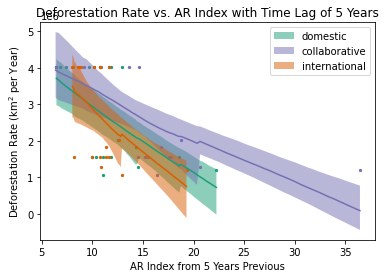

In [ ]:
variable_of_interest = 'AR_Index_5_Year_Prev'


[y_bootstrap_summary_domestic, x_array_domestic, MSE_min_domestic, optimal_poly_order_domestic] = bootstrap_polynomial_analysis(domestic_df_list[5], variable_of_interest, response, poly_order_max, len(domestic_df_list[5]))

plt.scatter(domestic_df_list[5][variable_of_interest], domestic_df_list[5][response], s=5, color=c_d)
plt.plot(x_array_domestic, y_bootstrap_summary_domestic['median'], c_d)
plt.fill_between(x_array_domestic, y_bootstrap_summary_domestic['95_CI_low'], y_bootstrap_summary_domestic['95_CI_high'], facecolor = c_d, alpha = 0.5, label='domestic')

[y_bootstrap_summary_collaborative, x_array_collaborative, MSE_min_collaborative, optimal_poly_order_collaborative] = bootstrap_polynomial_analysis(collaborative_df_list[5], variable_of_interest, response, poly_order_max, len(collaborative_df_list[5]))
plt.scatter(collaborative_df_list[5][variable_of_interest], collaborative_df_list[5][response], s=5, color=c_c)
plt.plot(x_array_collaborative, y_bootstrap_summary_collaborative['median'], c_c)
plt.fill_between(x_array_collaborative, y_bootstrap_summary_collaborative['95_CI_low'], y_bootstrap_summary_collaborative['95_CI_high'], facecolor = c_c, alpha = 0.5, label='collaborative')

[y_bootstrap_summary_international, x_array_international, MSE_min_international, optimal_poly_order_international] = bootstrap_polynomial_analysis(international_df_list[5], variable_of_interest, response, poly_order_max, len(international_df_list[5]))
plt.scatter(international_df_list[5][variable_of_interest],international_df_list[5][response], s=5, color=c_i)
plt.plot(x_array_international, y_bootstrap_summary_international['median'], c_i)
plt.fill_between(x_array_international, y_bootstrap_summary_international['95_CI_low'], y_bootstrap_summary_international['95_CI_high'], facecolor = c_i, alpha = 0.5, label='international')

plt.xlabel('AR Index from 5 Years Previous')
plt.ylabel(f'Deforestation Rate (km$^2$ per Year)')
plt.title(f'Deforestation Rate vs. AR Index with Time Lag of 5 Years')
plt.legend()
plt.show()